# Particle Flow Network to Handle Single Track Multiple Cluster Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUS - Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# get_available_gpus()

# Import EnergyFlow 

In [3]:
import energyflow as ef
from energyflow.archs import PFN
print('Energy Flow Version: '+str(ef.__version__))

Energy Flow Version: 1.3.2


# Load Data
### Data Including Tracks
### X = [Energy, Eta, Phi, rPerp, Track Flag, Layer]
### Y = [truthPartE, truthTrackPt, cluster_ENG_CALIB_TOT]

In [4]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/X_STMC_502_files.npy', mmap_mode='r')[:175000,:,:]
Yraw = np.load('/data/atlas/rbate/Y_STMC_502_files.npy', mmap_mode='r')[:175000,:]

X = np.lib.format.open_memmap('/data/atlas/rbate/X_STMC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/atlas/rbate/Y_STMC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

t1 = t.time()
print('Time to load memory mapped data: {} (s)'.format(t1-t0))
print(Xraw.shape)
print(Yraw.shape)

Time to load memory mapped data: 36.251779079437256 (s)
(175000, 1086, 6)
(175000, 3)


# Particle Truth Energy Target

In [5]:
# the target energy values
target_zero_mask = Yraw[:,0] > .05
Y = np.log(Yraw[target_zero_mask,0])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Any targets below 50 GeV: 0
Number of events: 175000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


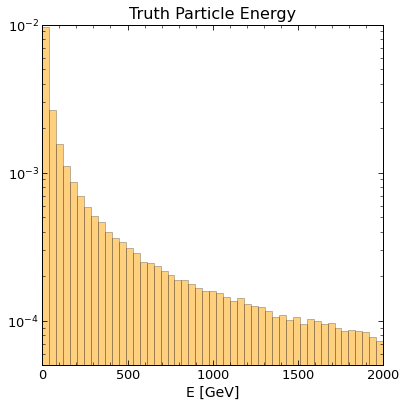

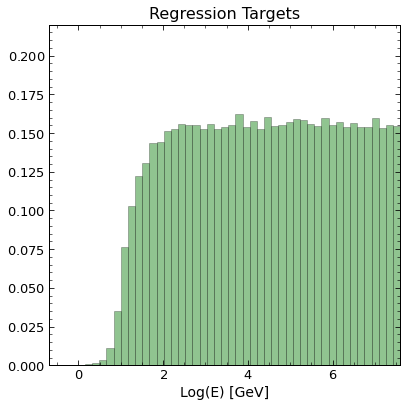

In [6]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[:,0][target_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='Particle Truth Energy')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STMC_raw_2021-07-26.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STMC_log_2021-07-26.png', format='png')
plt.show()

## Deep Set Normalization

In [7]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

isnan = np.isnan(X[:,:,0])
anytruth = np.any(isnan)
print(anytruth)

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

False
Time to Normalize: 9.380037546157837 (s)


## Show Inputs

<Figure size 799.992x599.976 with 0 Axes>

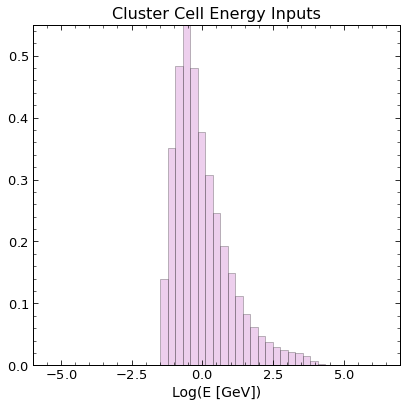

<Figure size 799.992x599.976 with 0 Axes>

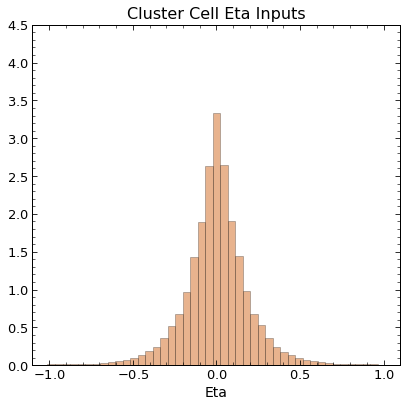

<Figure size 799.992x599.976 with 0 Axes>

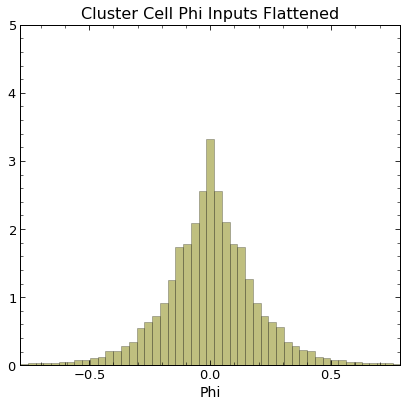

<Figure size 799.992x599.976 with 0 Axes>

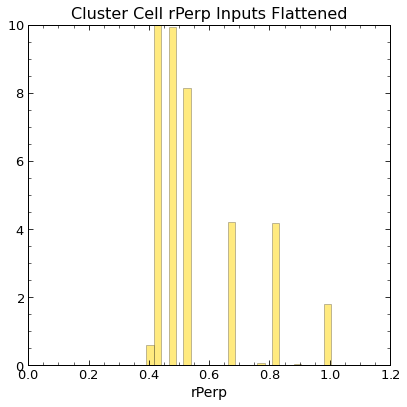

In [8]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_E_2021-07-26.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Eta_2021-07-26.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Phi_2021-07-26.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_rPerp_2021-07-26.png', format='png')
plt.show()

### Model Settings

In [9]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 3000

train -- val -- test
122500 -- 26250 -- 26250


#### Train/Val/Test Split

In [10]:
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(122500, 1086, 5)
(122500,)


### Build Particle Flow Network

In [11]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

2022-01-27 19:19:59.390597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


### Train Model

In [ ]:
t0 = t.time()
history = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1)
t1 = t.time()

2022-01-27 19:20:18.394645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1500
41/41 [==============================] - 12s 257ms/step - loss: 1097.8428 - val_loss: 25.5850
Epoch 2/1500
41/41 [==============================] - 10s 242ms/step - loss: 8.2171 - val_loss: 2.4251
Epoch 3/1500
41/41 [==============================] - 9s 209ms/step - loss: 2.3241 - val_loss: 1.8761
Epoch 4/1500
41/41 [==============================] - 9s 214ms/step - loss: 1.5687 - val_loss: 1.3791
Epoch 5/1500
41/41 [==============================] - 11s 261ms/step - loss: 1.2677 - val_loss: 1.1937
Epoch 6/1500
41/41 [==============================] - 10s 236ms/step - loss: 1.1238 - val_loss: 1.0075
Epoch 7/1500
41/41 [==============================] - 9s 230ms/step - loss: 0.9869 - val_loss: 0.9329
Epoch 8/1500
41/41 [==============================] - 9s 231ms/step - loss: 0.9194 - val_loss: 0.8610
Epoch 9/1500
41/41 [==============================] - 10s 233ms/step - loss: 0.8490 - val_loss: 0.9636
Epoch 10/1500
41/41 [==============================] - 9s 227ms/step - lo

In [ ]:
print('Time to train: {} (s)'.format(t1-t0))
print('{} (min)'.format(((t1-t0)/60))
print('{} (hour)'.format((t1-t0)/3600))

### Loss Curves

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
plt.text(1000, 1, 'Batch: 3000', fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/January/STMC_lossCurves_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Predictions

In [ ]:
preds = np.exp(pfn.predict(x_test, batch_size=3000).flatten())
print(preds.shape)

#### Histogram of Predictions

In [ ]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('Regression_Plots/January/STMC_targetPreds_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

#### Analytics

#### Response Plot

In [ ]:
resplot = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])
# Regression_Plots/July/STMC_responsePlot_3000batch_LR1e-3_2021-07-26.png

#### Resolution Plot

In [ ]:
resp_plot = ru.resolutionPlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                    figfile='',
                    statistic='iqrOverMean', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])
# Regression_Plots/July/STMC_resolutionPlot_3000batch_LR1e-3_2021-07-26.png

### Save Model and History

In [ ]:
pfn.save('Models/pfn_base_trained_STMC_122500_2022-01-26')

In [ ]:
import pickle

with open('Models/pfn_base_trained_STMC_122500_history_2022-01-26.pickle', "wb") as hist_file:
    pickle.dump(history, hist_file)

# Construct Models from Scratch

## Add Drop Out

In [ ]:
def point_mask_fn(X, mask_val=0.):
    return K.cast(K.any(K.not_equal(X, mask_val), axis=-1), K.dtype(X))

def ParticleFlow_base(num_points, num_features, name="Russell Flow Network"):
    
    inputs = keras.Input(shape=(num_points, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    masking_layer = layers.Masking(mask_value=0.0)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('relu', name="activation_6")(dense_6)
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

In [ ]:
# t0 = t.time()
# Xraw = np.load('/data/rbate/X_STMC_502_files.npy', mmap_mode='r')
# Yraw = np.load('/data/rbate/Y_STMC_502_files.npy', mmap_mode='r')

# X = np.lib.format.open_memmap('/data/rbate/X_STMC_notebook.npy',
#                              mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
# np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

# Y = np.lib.format.open_memmap('/data/rbate/Y_STMC_notebook.npy',
#                              mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
# np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

# t1 = t.time()
# print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

In [ ]:
# t0 = t.time()
# ## Normalize rPerp to 1/3630
# rPerp_mask = X[:,:,3] != 0
# X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

# ## Energy Values that are not zero!
# E_nonZeroMask = X[:,:,0] != 0
# X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
# cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
# cellE_std = np.std(X[:,:,0][E_nonZeroMask])
# X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

# ## Eta and Phi
# # do nothing for now as a control and check performance
# eta_mask = X[:,:,1] != 0
# X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

# phi_mask = X[:,:,2] != 0
# cellPhi_std = np.std(X[:,:,2][phi_mask])
# X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
# t1 = t.time()
# print('Time to Normalize: '+str(t1-t0)+' (s)')

#### Check array size

## Do more stuff

In [ ]:
# # EFN regression example uses 75/10/15 split for 100,000 samples
# train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
# print('train -- val -- test')
# print(str(train)+' -- '+str(val)+' -- '+str(test))

In [ ]:
# (x_train, x_val, x_test,
#  y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

In [ ]:
print(X.shape)

In [ ]:
# loadsize = 30000

# train_idx = np.arange(0,len(x_train),loadsize)
# val_idx = np.arange(0,)
# XR = np.empty((loadsize, X.shape[1], X.shape[2]))

# for i in range(0,len(X), loadsize):
#     XR = np.copy

### Loss Curves

In [ ]:
# fig = plt.figure(figsize=(6,6))
# plt.plot(history.history['val_loss'], label="Validation")
# plt.plot(history.history['loss'], label="Training")
# plt.yscale('log')
# plt.ylim(.001,10)
# plt.yticks(fontsize=13)
# plt.xlim(0,1500)
# plt.xticks(fontsize=13)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(loc='upper right', ncol=1)
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
# # plt.savefig('Regression_Plots/July/STMC_lossCurves_3000batch_LR1e-3_2021-07-26.png', format='png')
# plt.show()